# Analysis of base case situation # 

This notebook contains the analysis of the base case situation, i.e. the performance of the water management system if no policy is implemented in the future. This means that all policy levers were not used. Exploring the base case helps to explore the uncertainty space and defines how the KPIs perform if no policy is implemented. The latter is needed to be able to evaluate the performance of different policy options. 

For the base case situation, we evaluated the water management model under 5000 different scenarions.

Throughout the notebook, guiding insights and next steps in the analysis are discussed.

In [12]:
# import the libaries
from ema_workbench import load_results
from ema_workbench.analysis import parcoords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from ema_workbench.analysis import prim
import numpy as np
from ema_workbench.util import ema_logging
import pickle

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
# load the basecase results
experiments, outcomes = load_results('../results/basecase_results.tar.gz') 

[MainProcess/INFO] results loaded succesfully from C:\Users\irene\OneDrive\Documenten\GitHub\EPA1361\final assignment\results\basecase_results.tar.gz


In [7]:
outcomes_df = pd.DataFrame.from_dict(outcomes)
outcomes_df.head()

,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,A.4_Expected Annual Damage 0,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,1.013409e+09,0,0.643681,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,...,0,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,0.0
1,6.609048e+08,0,0.642450,2.246637e+06,0,0.003069,4.517969e+08,0,1.091859,0.0,...,0,1.091859,0.0,0,0.0,0.0,0,0.0,0.0,0.0
2,8.080002e+08,0,0.644351,4.230140e+05,0,0.000498,3.775395e+08,0,0.765847,0.0,...,0,0.765847,0.0,0,0.0,0.0,0,0.0,0.0,0.0
3,6.691150e+08,0,0.652516,1.281975e+06,0,0.001794,1.705024e+07,0,0.044883,0.0,...,0,0.044883,0.0,0,0.0,0.0,0,0.0,0.0,0.0
4,0.000000e+00,0,0.000000,2.773680e+07,0,0.038306,4.729676e+08,0,1.171957,0.0,...,0,1.171957,0.0,0,0.0,0.0,0,0.0,0.0,0.0


In [8]:
outcomes_df.columns

Index(['A.1_Expected Annual Damage 0', 'A.1_Dike Investment Costs 0',
       'A.1_Expected Number of Deaths 0', 'A.2_Expected Annual Damage 0',
       'A.2_Dike Investment Costs 0', 'A.2_Expected Number of Deaths 0',
       'A.3_Expected Annual Damage 0', 'A.3_Dike Investment Costs 0',
       'A.3_Expected Number of Deaths 0', 'A.4_Expected Annual Damage 0',
       'A.4_Dike Investment Costs 0', 'A.4_Expected Number of Deaths 0',
       'A.5_Expected Annual Damage 0', 'A.5_Dike Investment Costs 0',
       'A.5_Expected Number of Deaths 0', 'RfR Total Costs 0',
       'Expected Evacuation Costs 0', 'A.1_Expected Annual Damage 1',
       'A.1_Dike Investment Costs 1', 'A.1_Expected Number of Deaths 1',
       'A.2_Expected Annual Damage 1', 'A.2_Dike Investment Costs 1',
       'A.2_Expected Number of Deaths 1', 'A.3_Expected Annual Damage 1',
       'A.3_Dike Investment Costs 1', 'A.3_Expected Number of Deaths 1',
       'A.4_Expected Annual Damage 1', 'A.4_Dike Investment Costs 1',
   

The basecase results are presented in 17 different outcomes as some outcomes are measures specifically per location (A.1 to A.5) and for every possible stage of the possible policies (phase 0, 1 and 2 possible). To get meaningful insights that are also easily visually interpretable, we aggregate the outcomes into the following KPIs relevant for the base case: 

- Expected number of deaths (per location and in total)
- Expected annual damage (per location and in total)

We thus aggregate over time. The outcomes of costs for evacuation, room for the river (rfr), and dike heightening are not considered during the analysis of the base case as these all present policy levers which are not utilized during the base case. 

In [9]:
# function to aggregate over time and locations
def aggregate_df(df):
    df_aggregate_time = pd.DataFrame()
    df_aggregate_time_location = pd.DataFrame()
    locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    step = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in step]

            df_aggregate_time_location[metric + ' time aggregate'] = df[columns].sum(axis=1)
        else:
            for location in locations:
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate_time[location + '_' + metric + ' time aggregate'] = df[columns].sum(axis=1)
            
            columns_locations = [location + '_' + metric + ' time aggregate' for location in locations]
            df_aggregate_time_location[metric + ' time location aggregate'] = df_aggregate_time[columns_locations].sum(axis=1)
                    

    return df_aggregate_time, df_aggregate_time_location

In [10]:
df_t, df_tl = aggregate_df(outcomes_df)
df_tl.head()

,Expected Annual Damage time location aggregate,Dike Investment Costs time location aggregate,Expected Number of Deaths time location aggregate,RfR Total Costs time aggregate,Expected Evacuation Costs time aggregate
0,2.834163e+09,0,1.931043,0.0,0.0
1,5.035985e+09,0,5.212136,0.0,0.0
2,3.860589e+09,0,4.232087,0.0,0.0
3,2.891039e+09,0,2.097578,0.0,0.0
4,1.878022e+09,0,3.630789,0.0,0.0


In [13]:
# determine the range of the outcomes which can be achieved 
max_range = df_tl.max()
min_range = df_tl.min()

with open('../results/min_max_range_basecase.pickle', 'wb') as f:
    pickle.dump([max_range, min_range], f)

### Local differences in damage costs and deaths ###

Now that we have the relevant KPIs, we start by analyzing the expected damage costs and expected deaths over the total of the water management project, i.e. aggregated over both time and locations. To this end, we use violin plots. The violin plot shows on the x-axis the smoothed probability density, i.e. the wider, the higher the frequency of a particular outcome value. The vertical thick black line shows the interquartile range (IQR), the white marker shows the median value, and the vertical thin black line denotes the range equal to 1.5 times the IQR.

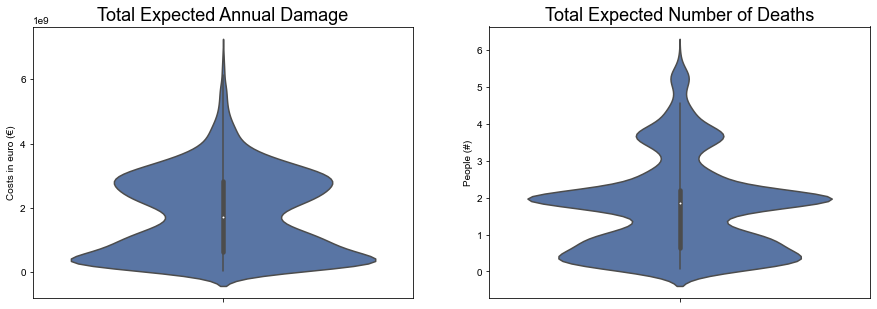

In [7]:
# plotting aggregated deaths and damage costs
f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.set(style="whitegrid", font_scale=1.5)
plt.rcParams["axes.labelsize"] = 15

sns.violinplot(data=df_tl["Expected Annual Damage time location aggregate"], ax=axes[0])
sns.violinplot(data=df_tl["Expected Number of Deaths time location aggregate"], ax=axes[1])

axes[0].set_title("Total Expected Annual Damage")
axes[0].set_ylabel('Costs in euro (€)')
axes[0].set(xticklabels = [])
axes[1].set_title("Total Expected Number of Deaths")
axes[1].set_ylabel('People (#)')
axes[1].set(xticklabels = [])

plt.show()

From the figures we can see that while there is a bulk of scenarios under which the damage costs and/or the deaths are acceptible low, there also are numerous scenarios under which the KPIs perform so undesired that the need for a novel water managemetn policy becomes clear. 

Aggegrating over locations prevents to observe if certain areas will be more vulnerable to water mismanagement than others. Therefore, we also expore the performance of the KPIs only aggregated over time.

In [8]:
# define the names of the KPIs of interest
locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
columns_damage = [location + '_' + 'Expected Annual Damage time aggregate'  for location in locations]
columns_deaths = [location + '_' + 'Expected Number of Deaths time aggregate' for location in locations]

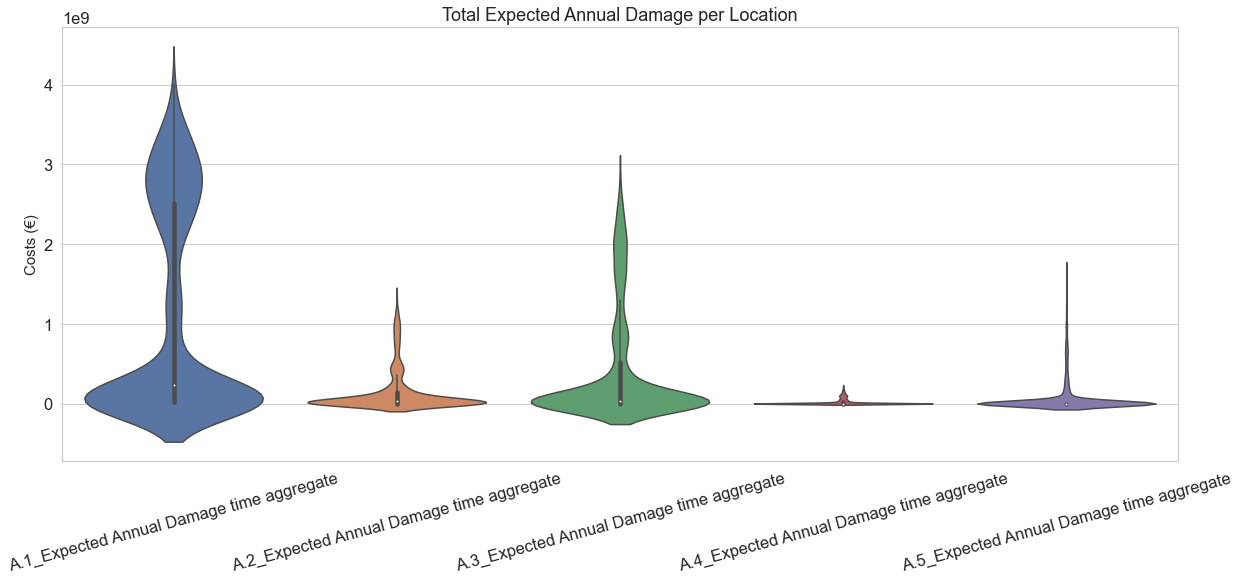

In [9]:
# damage costs per location, aggregated over time
f, axes = plt.subplots(1, 1, figsize=(20,8))
sns.set(style="whitegrid", font_scale=1.5)

sns.violinplot(data=df_t[columns_damage], ax=axes, scale='count')
plt.xticks(rotation=15)
plt.rcParams["axes.labelsize"] = 18

axes.set_title("Total Expected Annual Damage per Location")
axes.set_ylabel('Costs (€)')

plt.savefig("../images/basebase_annualdamagelocations.png")
plt.show()

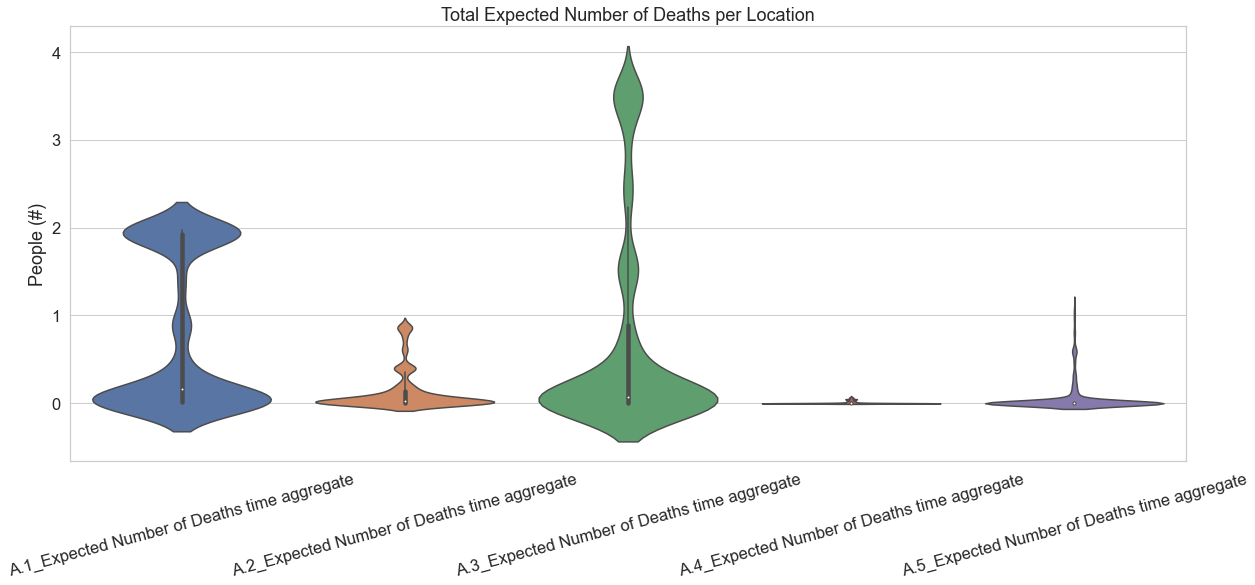

In [10]:
# damage costs per location, aggregated over time
f, axes = plt.subplots(1, 1, figsize=(20,8))
sns.set(style="whitegrid", font_scale=1.5)

sns.violinplot(data=df_t[columns_deaths], ax=axes, scale='count')
plt.xticks(rotation=15)
plt.rcParams["axes.labelsize"] = 18

axes.set_title("Total Expected Number of Deaths per Location")
axes.set_ylabel('People (#)')

plt.savefig("../images/basebase_deathslocations.png")
plt.show()

From the above figures it becomes clear that locations A1 and A3 suffer the most if no policy is implemented. Both the deaths and damage costs are outstandly higher in these locations relative to the other locations. Additionally, it can be noted that these locations have more outiers, i.e. there are relively more scenarios under which these locations will be impacted expectionally bad relative to the other locations. 

### Analysis of variance between locations: Disadvanted locations under certain scenarios ###

The differences between the locations are interesting and need more exploration. The observed differences in impact between locations could be the result of two underlying phenomena: (i) under certain scenarios the KPIs are performing relatively bad for all locations, but due to differences in magnitude this underlying trend is hard to observe, or (ii) under certain scenarios there are one or more locations at which the KPIs are performing relatively bad, but they relatively good for other locations. 'Relatively' in this context means with respect to the other outcomes per location, so for instance being among the worst 10% of scenarios for a certain location. 

To investigate this, we first scaled all outcomes to a unit interval to remove the influences of differences in magnitude, and consequently calculated the variance in normalized KPI performance among the different locations. 

In [11]:
# function to calculate the normaized variance in KPI performance
# between different locations

def unit_variance(df, kpi):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df['variance ' + kpi] = df.var(axis=1)
    
    return df
    
df_damage = unit_variance(df_t[columns_damage], 'expected annual damage')
df_deaths = unit_variance(df_t[columns_deaths], 'expected number of deaths')
df_damage.head()

,0,1,2,3,4,variance expected annual damage
0,0.707983,0.000000,0.000000,0.0,0.0,0.100248
1,0.745705,0.007476,0.713576,0.0,0.0,0.158762
2,0.657041,0.001014,0.429746,0.0,0.0,0.094931
3,0.702932,0.003972,0.025073,0.0,0.0,0.096900
4,0.000000,0.076640,0.620323,0.0,0.0,0.073381


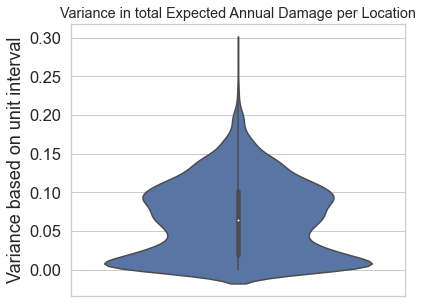

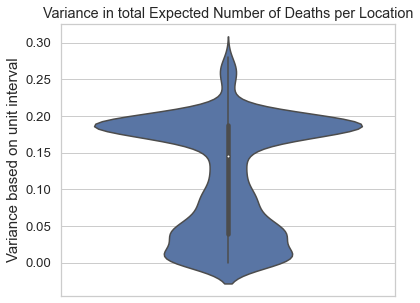

In [12]:
# visualize the variance 
f, axes = plt.subplots(1, 1, figsize=(6,5))
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["axes.labelsize"] = 15

sns.violinplot(data=df_damage["variance expected annual damage"], ax=axes)

axes.set_title("Variance in total Expected Annual Damage per Location")
axes.set_ylabel('Variance based on unit interval')
axes.set(xticklabels = [])

plt.savefig("../images/basecase_variancecosts.png")
plt.show()

f, axes = plt.subplots(1, 1, figsize=(6,5))
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["axes.labelsize"] = 15

sns.violinplot(data=df_deaths["variance expected number of deaths"], ax=axes)

axes.set_title("Variance in total Expected Number of Deaths per Location")
axes.set_ylabel('Variance based on unit interval')
axes.set(xticklabels = [])

plt.savefig("../images/basecase_variancedeaths.png")
plt.show()

For the damage costs, there are a few scenarios under which there is a large variance between locations. This indicates that the costs are likely evenly distributed, so e.g. in case of high costs, most locations will have high costs. 

For the amount of deaths, however, there is a substantial amount of scenarios under which the variance in quite high. While these insights hint that under certain scenarios the locations are indeed unevenly impacted (hypothesis ii), it is also of importance whether the variance is caused by an outlier that lies above the average or below. Specifically, a certain location may be more disadvantaged if multiple locations have e.g. few deaths and one location a high number of deaths than multiple locations having relatively high deaths and one location few deaths. A relatively low mean with high variance would thus indicate a disadvantaged location.

To investigate this mean vs. variance relation, we also calculte the mean value for each KPI per scenario over all locations. Next, we visualize these results

In [13]:
# calculate the means
df_damage['mean expected annual damage'] = df_damage.mean(axis=1)
df_deaths['mean expected number of deaths'] = df_deaths.mean(axis=1)

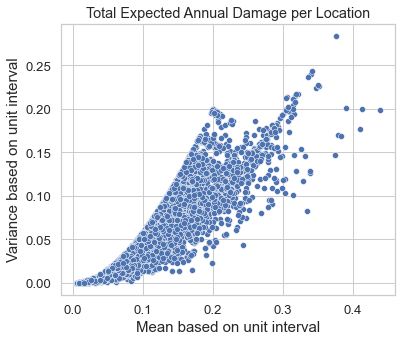

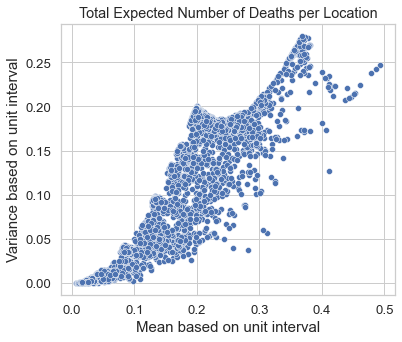

In [14]:
# visualize the results
f, axes = plt.subplots(1, 1, figsize=(6,5))
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["axes.labelsize"] = 15

sns.scatterplot( x=df_damage['mean expected annual damage'], y=df_damage["variance expected annual damage"], ax=axes)

axes.set_title("Total Expected Annual Damage per Location")
axes.set_ylabel('Variance based on unit interval')
axes.set_xlabel('Mean based on unit interval')

plt.savefig("../images/basecase_variancecostsmean.png")
plt.show()

f, axes = plt.subplots(1, 1, figsize=(6,5))
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["axes.labelsize"] = 15

sns.scatterplot( x=df_deaths['mean expected number of deaths'], y=df_deaths['variance expected number of deaths'], ax=axes)

axes.set_title("Total Expected Number of Deaths per Location")
axes.set_ylabel('Variance based on unit interval')
axes.set_xlabel('Mean based on unit interval')

plt.savefig("../images/basecase_variancedeathsmean.png")
plt.show()

There indeed can be scenarios observed under which there are disadvantaged locations, indicated by a relatively low main and high variance.

### Scenario discovery ###

As there are scenarios under which either there are undesirable outcomes or disadvantages locations, or both, it is important to identify these scenarios. Hence, we execute a scenario discovery analysis using the Patient Rule Induction Method (PRIM), which is incorporated in the EMA workbench. PRIM was designed by Friedman & Fisher (1999) and is a technique that iteratively narrows down the uncertainty space until "boxes" are found representing certain uncertainty intervals that form a good trade-off between coverage (what fraction of the total outcomes of interest are in the box) and density (what fraction of all cases in the box are actually of interest).

Scenarios were classified as undesirable if they resulted in high damage costs, many deaths, and have a high variance among different locations in effects. As such, a search for scenarios that are simultaneously among the 25% of the worst outcomes for death and damage costs as well as being among the 50% of the worst outcomes with high disadvantaged locations. This resulted in the selection of 579 scenarios of interest. With the higher threshold for deaths and damage costs, it was ensured that the scenario search focused more secondary on the variance among locations. Specifically, restricting the scenario search harder for on the KPI of variance among location could result in scenarios with only high damage costs and deaths and low variance being disregarded, while these are also of key interest.

In [15]:
# first, we get all the relevant model input values
experiments.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'scenario', 'policy', 'model'],
      dtype='object')

In [16]:
# since we are not using levers yet, we can remove al inputs about RfR, 
# dike increase, and evacuation time
cleaned_experiments = experiments.iloc[:,:19]
cleaned_experiments.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,120.0,328.258722,10.0,0.260546,157.899401,1.5,0.281308,305.222534,1.0,0.463477,313.527653,1.0,0.673334,330.393983,1.0,0.495776,2.5,3.5,2.5
1,80.0,110.334051,1.5,0.017652,325.699902,1.0,0.453142,68.363886,1.0,0.009517,236.343486,10.0,0.702819,316.576417,1.5,0.541064,4.5,2.5,1.5
2,107.0,56.203230,1.0,0.141758,151.279111,10.0,0.809645,280.757083,10.0,0.138378,62.327005,10.0,0.856523,141.520666,1.0,0.100371,3.5,2.5,3.5
3,67.0,86.292293,1.5,0.039247,273.870313,1.5,0.649279,47.393685,10.0,0.461976,123.908748,1.0,0.712965,337.775686,1.5,0.694071,4.5,1.5,3.5
4,108.0,307.569879,10.0,0.911493,318.727883,10.0,0.365281,298.355358,10.0,0.037761,340.969706,1.0,0.619066,46.545702,1.0,0.987600,4.5,2.5,3.5


[MainProcess/INFO] 5000 points remaining, containing 579 cases of interest
[MainProcess/INFO] mean: 0.8692307692307693, mass: 0.052, coverage: 0.3903281519861831, density: 0.8692307692307693 restricted_dimensions: 6


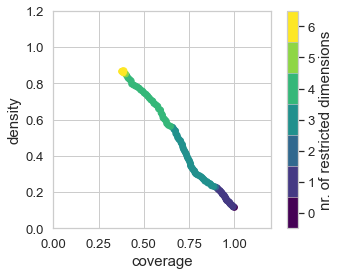

In [17]:
# Calculate the value (threshold) where the upper 25% range starts for the total number of deaths and 
# damage costs and the upper 50% range for their respective variances
percentile_vardamage = np.percentile(df_damage["variance expected annual damage"], 50)
percentile_vardeaths = np.percentile(df_deaths['variance expected number of deaths'], 50)
percentile_damage = np.percentile(df_tl["Expected Annual Damage time location aggregate"], 75)
percentile_deaths = np.percentile(df_tl["Expected Number of Deaths time location aggregate"], 75)

# Bool the values if they are larger than the threshold
bools = pd.DataFrame()
bools["Cost_bool"] = df_tl["Expected Annual Damage time location aggregate"] > percentile_damage
bools["Death_bool"] = df_tl["Expected Number of Deaths time location aggregate"] > percentile_deaths
bools["Varcost_bool"] = df_damage["variance expected annual damage"] > percentile_vardamage
bools["Vardeath_bool"] = df_deaths['variance expected number of deaths'] > percentile_vardeaths

# If cost and deaths are in the 75th upper percentiles indicate true
# and either one of their variances is in the upper 50th percentille
y1 = bools["Cost_bool"] & bools["Death_bool"] 
y2 = bools["Varcost_bool"] | bools["Vardeath_bool"]
y3 = y1 & y2
y3.to_csv('../results/boolean_worst_scenarios.csv')

# Execute prim algorithm
# We select the value for peel_alpha by trial and error such that we get all the dimensions as output 
# as well as a threshold above 0.65
prim_alg = prim.Prim(cleaned_experiments, y3, threshold=0.65, peel_alpha=0.0285)
box1 = prim_alg.find_box()

# Show trade off plot
box1.show_tradeoff()
plt.show()

Fro the iterative PRIM process, it is important that a good box is selected. This mean that it properly trades off density and coverage. In the ideal case, the density should be around 0.8, but in the PRIM process executed here selecting for a box with that density would result in a quite low coverage of 0.3. Therefore, a box has been chosen with a slightly lower density of 0.790, so that coverage is still somewhat representative. This does mean that we include only 4 dimensions in the consequent PRIM analysis while 6 dimensions have been restricted. However, while inspecting these additional dimensions, we noted they all were not significant (p-value > 0.05) and therefore we can confidently drop them from consideration in the search for variables that contributed to undesirable outcomes. 

In [18]:
# Choosing the best box and inspecting the corresponding coverage, density and uncertainty ranges.
box1.inspect(93, style='table')
box1.select(93)
plt.show()

coverage    0.443869
density     0.790769
id                93
mass           0.065
mean        0.790769
res_dim            4
Name: 93, dtype: object

              box 93                                            
                 min         max                       qp values
A.3_pfail   0.000010    0.181847  [-1.0, 2.0161207454624657e-85]
A.1_pfail   0.000120    0.414252  [-1.0, 2.0337529475302877e-39]
A.1_Bmax   30.012525  298.534935     [-1.0, 0.01568112673981688]
A.4_Bmax   39.275594  349.965209       [0.439865757792356, -1.0]



Based on the above statistics, we can observe that three model variables (A.1 pfail, A.3 pfail, and A.1 Bmax) have a statistical significant relation on the scenarios of interest. 

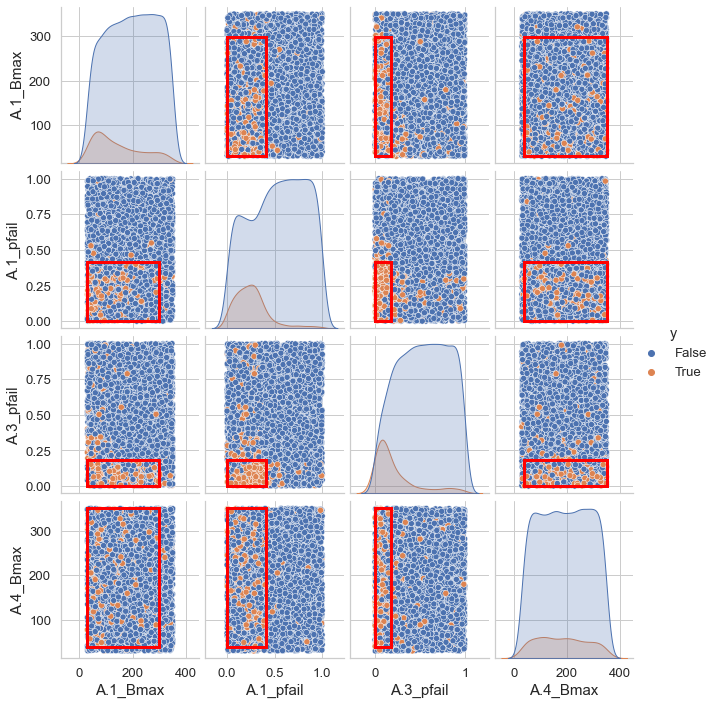

In [19]:
# visualizing the results of PRIM
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.savefig("../images/PRIM_results_distributionmatrix.png")
plt.show()

The above plot visually confirms the statistics previously obtained. We can see that especially A.3 pfail and A.1 pfail combined allow for a strict bounded box to be found by the prim algorithm. Given the selected threshold for the algorithm, we can see how some of the orange dots are outside of the boundary box. This suggests how the boundaries are indicative and not normative.

Indeed, when using dimensional stacking (see below), the best feature scores can be upserved in the upper quadrats, which relate to a intervals found by PRIM. There are also a few high feature scores observable outside the upper quadrants, which correspond to the points outside the boxes drawn by the prim algorithm.

Given the harder interpretability of dimensional stacking, this part was not included in the report. 

C:\Users\Willy\Anaconda3\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


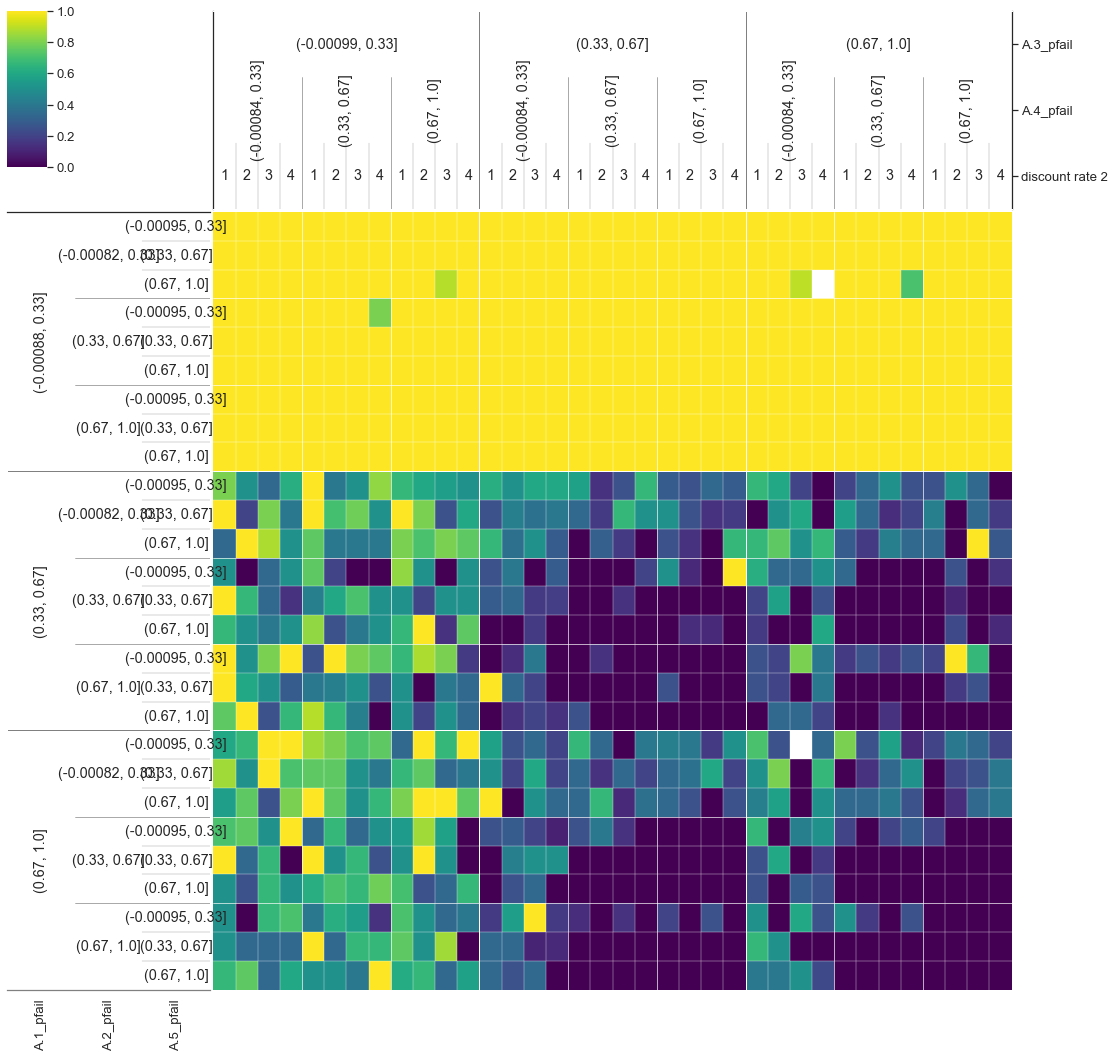

In [20]:
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(cleaned_experiments, y2, nr_levels=3, bin_labels=True)
fig = plt.gcf()
fig.set_size_inches(18,18)
plt.show()